<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-модулей" data-toc-modified-id="Загрузка-модулей-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка модулей</a></span></li><li><span><a href="#Настройки" data-toc-modified-id="Настройки-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Настройки</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Вывод-этапа" data-toc-modified-id="Вывод-этапа-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Вывод этапа</a></span></li></ul></li><li><span><a href="#Обработка" data-toc-modified-id="Обработка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обработка</a></span><ul class="toc-item"><li><span><a href="#Вывод-этапа" data-toc-modified-id="Вывод-этапа-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод этапа</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Без-балансировки" data-toc-modified-id="Без-балансировки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Без балансировки</a></span></li><li><span><a href="#Уменьшение-выборки" data-toc-modified-id="Уменьшение-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Уменьшение выборки</a></span></li><li><span><a href="#Вывод-этапа" data-toc-modified-id="Вывод-этапа-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Вывод этапа</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» без BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.
   
**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
#!pip install optuna
#!pip install optuna-dashboard
#!pip install hyperopt
#!pip install sweetviz
#!pip3 install pandas-profiling==3.0.0

### Загрузка модулей

In [2]:
import time
import pandas as pd
import optuna

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

import nltk
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from pymystem3 import Mystem
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import re

import warnings
warnings.filterwarnings("ignore")

### Настройки

In [3]:
RANDOM_STATE = 853973
state = np.random.RandomState(RANDOM_STATE)
# Цветовая палитра документа
cm = 'crest'
mec = 'gray'
alpha = 0.7
fontsize = 16
figsize_base = 5

def new_color(x='r'):
    '''Цвет графиков, по умолчанию случайный из заданной цветовой палитры. Принимает в качестве аргумента число, \
    соответствующее цвету в палитре.'''
    if x == 'r':
        return list(sns.color_palette(cm, 20)[random.randint(0,19)])
    return list(sns.color_palette(cm, 20)[x])
# Размеры

def figsize(width = 1, height=1):
    '''Задание размеров окна отрисовки.'''
    return (width*figsize_base, height*figsize_base)

# Отрисовка 
def plot_set(ax,title='',xlabel='',ylabel='',fontsize=fontsize,xrot=1,figsize=figsize(),theme = 'darkgrid'):
    '''Функция для отрисовки дополнительных параметров графиков. Подписьи осей и названия, размер шрифта и размер окна, 
    включение сетки.'''
    sns.set_style(theme)
    plt.xticks(rotation=45*int(xrot), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.title(title+'\n', fontsize=fontsize)
    plt.xlabel('\n'+xlabel, fontsize=fontsize)
    plt.ylabel(ylabel+'\n', fontsize=fontsize)
    plt.grid(visible=True, which='both')
    None
    
def mean_percent(x):
    '''Функция для форматирования значений. Округление до сотых и знак процента.'''
    try:
        return "{0:.2%}".format(x)
    except:
        return x

### Загрузка данных

In [4]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('toxic_comments.csv')

In [5]:
df.head(25)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [7]:
df.describe()

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


In [8]:
df.isna().mean().sort_values().apply(mean_percent)

Unnamed: 0    0.00%
text          0.00%
toxic         0.00%
dtype: object

### Вывод этапа

Изучен датафрейм `toxic_comments.csv`:
- 3 столбца:
    - `Unnamed: 0` — индекс строки в данных
    - `text` — текст комментария
    - `toxic` — токсичность комментария

- 159292 строк
- Пропусков нет
- Дубликатов не наблюдается

## Обработка

В данных присутствуют разделители строки, заглавные символы. Очистим.

In [9]:
def cleaning(text):
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()
    text = text.lower()
    return text

df['text'] = df['text'].apply(cleaning)

Проведём лемматизацию.

In [10]:
corpus = df['text'].values

In [11]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Фаиль\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
lemmatizer = WordNetLemmatizer()

In [13]:
def lemmatize(text):
    token = nltk.word_tokenize(text)
    text = [word for word in token]
    text = [lemmatizer.lemmatize(word,pos='v') for word in text]
    text = ' '.join(text)
    return text

In [14]:
tqdm.pandas()
df['lemm_text'] = df['text'].progress_apply(lemmatize)

100%|████████████████████████████████████████████████████████████████████████| 159292/159292 [01:11<00:00, 2234.31it/s]


In [15]:
sentence1 = "The striped bats are hanging on their feet for best" 
sentence2 = "you should be ashamed of yourself went worked" 
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text']) 
print(df_my)

print(df_my['text'].apply(lemmatize))

                                                text
0  The striped bats are hanging on their feet for...
1      you should be ashamed of yourself went worked
0    The strip bat be hang on their feet for best
1       you should be ashamed of yourself go work
Name: text, dtype: object


Разделим выборку на обучающую, валидационную и тестовую в пропорции 70% : 15% : 15%

In [16]:
Y = df['toxic']
X = df['text']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = RANDOM_STATE,stratify=Y)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, test_size = .5, random_state = RANDOM_STATE,stratify=Y_test)
X_train.shape[0], X_test.shape[0]

(111504, 23894)

Очистим от стоп-слов.

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Фаиль\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
count_tf_idf = TfidfVectorizer(stop_words='english')

Проведём векторизацию.

In [19]:
X_train_tfd = count_tf_idf.fit_transform(X_train)
X_valid_tfd = count_tf_idf.transform(X_valid)
X_test_tfd = count_tf_idf.transform(X_test)

Оценим баланс классов

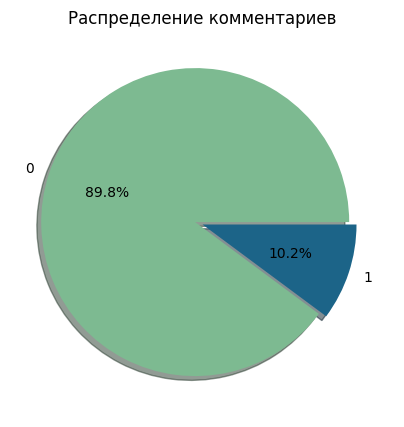

In [20]:
Y.value_counts().plot(
    kind = 'pie',
    autopct = '%0.01f%%',
    figsize=figsize(), 
    title = 'Распределение комментариев',
    colors=[new_color(2),new_color(14)],explode = (0.05,0), shadow=True);
plt.ylabel('')
None

### Вывод этапа

- Данные очищены от лишних символов;
- Проведена лемматизация;
- Проведена векторизация с удалением стоп-слов;
- Число нетоксичных комментариев почти в девять раз превышает число токсичных;
- Выборка разделена на обучающую, валидационную и тестовую в пропорции 70% : 15% : 15%.

## Обучение

Зададим функцию для оценки качества модели. В качестве моделей рассмотрим `LogisticRegression`, `XGBClassifier` и `LGBMClassifier`.

In [21]:
def score_and_plot(model_name, X_train_tfd, Y_train, X_valid_tfd, Y_valid):
    if model_name == 'line':
         model = LogisticRegression(**params_line, random_state=RANDOM_STATE)
    elif model_name == 'xg_boost':
            model = xgb.XGBClassifier(**params_xg_boost, random_state=RANDOM_STATE)
    elif model_name == 'light_GBM':
            model = LGBMClassifier(**params_light_GBM, random_state=RANDOM_STATE, verbose=0)
    model.fit(X_train_tfd, Y_train)
    predictions_valid = model.predict(X_valid_tfd)
    probabilities_one_valid = model.predict_proba(X_valid_tfd)[:, 1]
    
    print('Метрики на валидационной выборке:')
    print('ROC-AUC:', roc_auc_score(Y_valid, probabilities_one_valid))
    print('F1:', f1_score(Y_valid, predictions_valid))
    print('Precision:', precision_score(Y_valid, predictions_valid))
    print('Recall:', recall_score(Y_valid, predictions_valid))
    print('Accuracy:', accuracy_score(Y_valid, predictions_valid))
    print()
    
    plt.figure(figsize=figsize(2))
    ax1 = plt.subplot(1,2,1)
    c_mat = confusion_matrix(y_pred = predictions_valid, y_true=Y_valid,
                          normalize='true')
    
    ConfusionMatrixDisplay(confusion_matrix=c_mat).plot(ax=ax1,cmap=cm)
    ax2 = plt.subplot(1,2,2)
    fpr, tpr, thresholds = roc_curve(Y_valid, probabilities_one_valid) 
    plt.plot(fpr, tpr, linestyle='solid', color=new_color(3))
    plt.plot([0, 1], [0, 1], linestyle='--',color=new_color(14))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')

### Подбор параметров

Оценим модели без учёта дисбаланса классов.

In [22]:
def objective(trial,features=X_train,target=Y_train):
    if model_type == 'line':
        param = {
            'solver': trial.suggest_categorical('solver', ['liblinear']),
            'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
            'C': trial.suggest_float('C', 5, 15),
        }
        model = LogisticRegression(**param, random_state=RANDOM_STATE)
    elif model_type == 'xg_boost':
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 150),
            'max_depth': trial.suggest_int('max_depth', 2, 10),
        }
        model = xgb.XGBClassifier(**param, random_state=RANDOM_STATE)

    
    elif model_type == 'light_GBM':
        
        param = {
            'num_leaves': trial.suggest_int('num_leaves', 20, 150), 
            'learning_rate': trial.suggest_float('learning_rate', .05, .5),
            'n_estimators': trial.suggest_int('n_estimators', 50, 150)
        }
            
        model = LGBMClassifier(**param, random_state=RANDOM_STATE)
    
    count_tf_idf = TfidfVectorizer(stop_words='english')
    
    pipeline = Pipeline([('transformer', count_tf_idf), ('estimator', model)])
    
    score = cross_val_score(pipeline, features, target, cv = 3, scoring='f1', n_jobs = 2).mean()
    
    return score

F1 кросс-валидации: 0.77

Метрики на валидационной выборке:
ROC-AUC: 0.9618097355904458
F1: 0.7825506343200533
Precision: 0.8513317191283293
Recall: 0.7240527182866557
Accuracy: 0.9591110739097681

CPU times: total: 6.88 s
Wall time: 2min 15s


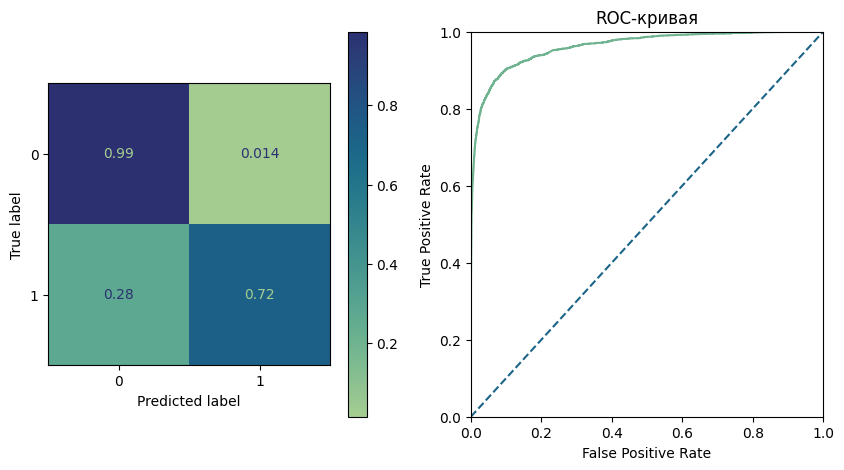

In [23]:
%%time
sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)
optuna.logging.set_verbosity(optuna.logging.WARNING)
model_type = 'line'
study_line = optuna.create_study(study_name="line",
                                   direction="maximize",
                                   sampler=sampler
                                   )
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_line.optimize(objective, n_trials=10)

# выводим результаты на обучающей выборке
#print("Наилучшие значения гиперпараметров {}".format(study_xg_boost.best_params))
print("F1 кросс-валидации: {:.2f}".format(study_line.best_value))
print()
params_line = study_line.best_params
score_line = study_line.best_value

score_and_plot(model_type, X_train_tfd, Y_train, X_valid_tfd, Y_valid)

F1 кросс-валидации: 0.73

Метрики на валидационной выборке:
ROC-AUC: 0.9494528798539846
F1: 0.7299950908198332
Precision: 0.9034021871202916
Recall: 0.6124382207578254
Accuracy: 0.9539633380765046

CPU times: total: 9min 21s
Wall time: 11min 8s


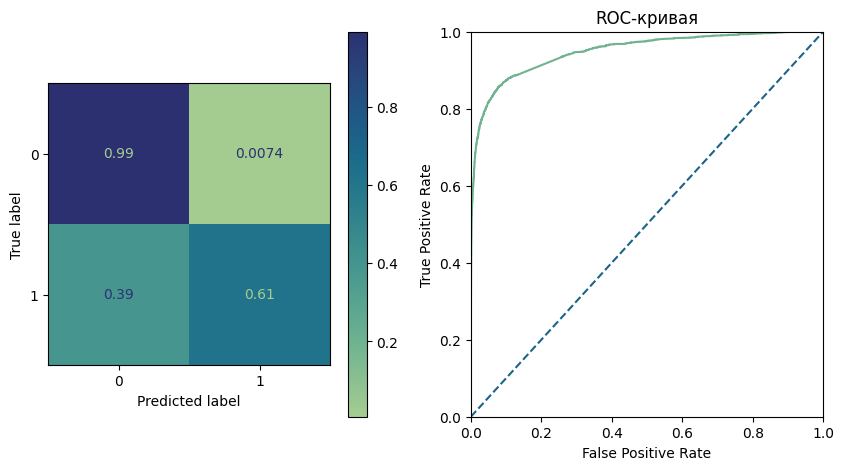

In [24]:
%%time
sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)
optuna.logging.set_verbosity(optuna.logging.WARNING)
model_type = 'xg_boost'
study_xg_boost = optuna.create_study(study_name="xg_boost",
                                   direction="maximize",
                                   sampler=sampler
                                   )
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_xg_boost.optimize(objective, n_trials=10)

# выводим результаты на обучающей выборке
#print("Наилучшие значения гиперпараметров {}".format(study_xg_boost.best_params))
print("F1 кросс-валидации: {:.2f}".format(study_xg_boost.best_value))
print()
params_xg_boost = study_xg_boost.best_params
score_xg_boost = study_xg_boost.best_value


score_and_plot(model_type, X_train_tfd, Y_train, X_valid_tfd, Y_valid)

F1 кросс-валидации: 0.76

Метрики на валидационной выборке:
ROC-AUC: 0.9625659024631266
F1: 0.7751615881809787
Precision: 0.881827731092437
Recall: 0.6915156507413509
Accuracy: 0.9592366284422867

CPU times: total: 5min 41s
Wall time: 11min 30s


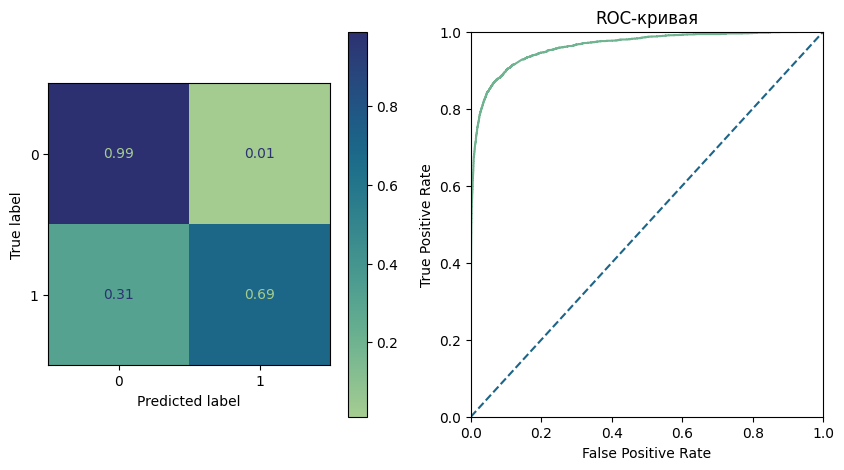

In [25]:
%%time
model_type = 'light_GBM'
sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_light_GBM = optuna.create_study(study_name="light_GBM",
                                   direction="maximize",
                                      sampler=sampler
                                   )
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_light_GBM.optimize(objective, n_trials=10)

# выводим результаты на обучающей выборке
#print("Наилучшие значения гиперпараметров {}".format(study_light_GBM.best_params))
print("F1 кросс-валидации: {:.2f}".format(study_light_GBM.best_value))
print()
params_light_GBM = study_light_GBM.best_params
score_light_GBM = study_light_GBM.best_value

score_and_plot(model_type, X_train_tfd, Y_train, X_valid_tfd, Y_valid)

Лучшие показатели у модели `LGBMClassifier` с F1 = 0.78

### Вывод этапа

- Рассмотрены модели `LogisticRegression`, `XGBClassifier` и `LGBMClassifier`
- Лучшей моделью оказалась `LogisticRegression` с F1 = 0.78

## Тестирование модели

В качестве итоговой модели выберем `LogisticRegression`.

In [28]:
best_model = 'line'

Метрики на валидационной выборке:
ROC-AUC: 0.9628005077874195
F1: 0.7782186948853614
Precision: 0.8372865275142315
Recall: 0.7269357495881383
Accuracy: 0.9578973800954215



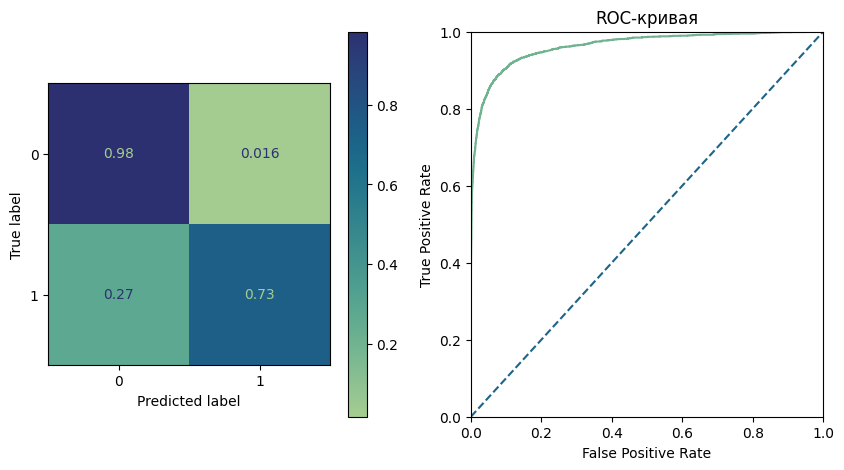

In [29]:
score_and_plot(best_model, X_train_tfd, Y_train, X_test_tfd, Y_test)

F1 на тестовой выборке 0.78, что больше требуемых 0.75.

## Выводы

- Изучен датафрейм `toxic_comments.csv`:
    - 3 столбца:
        - `Unnamed: 0` — индекс строки в данных
        - `text` — текст комментария
        - `toxic` — токсичность комментария
    - 159292 строк
    - Пропусков нет
    - Дубликатов не наблюдается
    - Число нетоксичных комментариев почти в девять раз превышает число токсичных;
- Данные обработаны: 
    - Данные очищены от лишних символов;
    - Проведена лемматизация;
    - Проведена векторизация с удалением стоп-слов;
- Обучены модели:
    - Выборка разделена на обучающую, валидационную и тестовую в пропорции 70% : 15% : 15%.
    - Рассмотрены модели `LogisticRegression`, `XGBClassifier` и `LGBMClassifier`
    - Лучшей моделью оказалась `LogisticRegression` с F1 = 0.78
- F1 на тестовой выборке 0.78, что больше требуемых 0.75.